# Magnetic B-field measurements

1.0122109751335835e-05 [7.582608964979957e-07]
2.2621755485722825e-06 [7.582608964979957e-07, 5.868906985742006e-07]
2.9748452660289298e-05 [7.582608964979957e-07, 5.868906985742006e-07, 1.1636036495001797e-06]
1.5386872567535385e-05 [7.37500856320103e-07]
3.3117590722853035e-06 [7.37500856320103e-07, 5.631779199853357e-07]
1.3093677952214249e-06 [7.37500856320103e-07, 5.631779199853357e-07, 5.393890465250522e-07]
4.497610397704423e-05 [7.37500856320103e-07, 5.631779199853357e-07, 5.393890465250522e-07, 1.0222409615704678e-06]
0.0003095684724080534 [2.9363315385775676e-06]
7.02578352661012e-05 [2.9363315385775676e-06, 6.31148673027724e-07]
2.6274816609220002e-05 [2.9363315385775676e-06, 6.31148673027724e-07, 5.883874044452878e-07]
0.00089835852892565 [2.9363315385775676e-06, 6.31148673027724e-07, 5.883874044452878e-07, 4.680237902287782e-06]


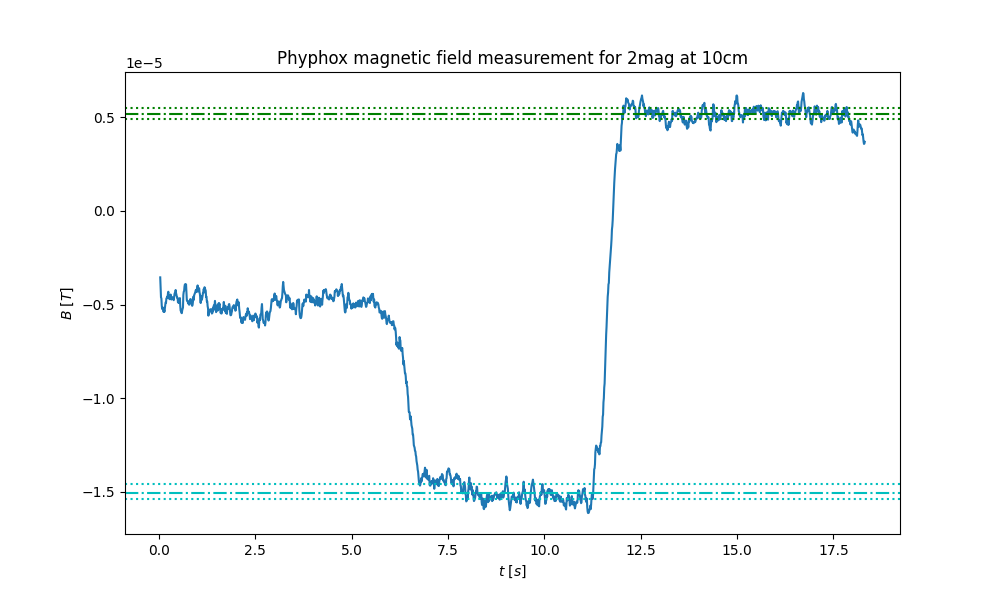

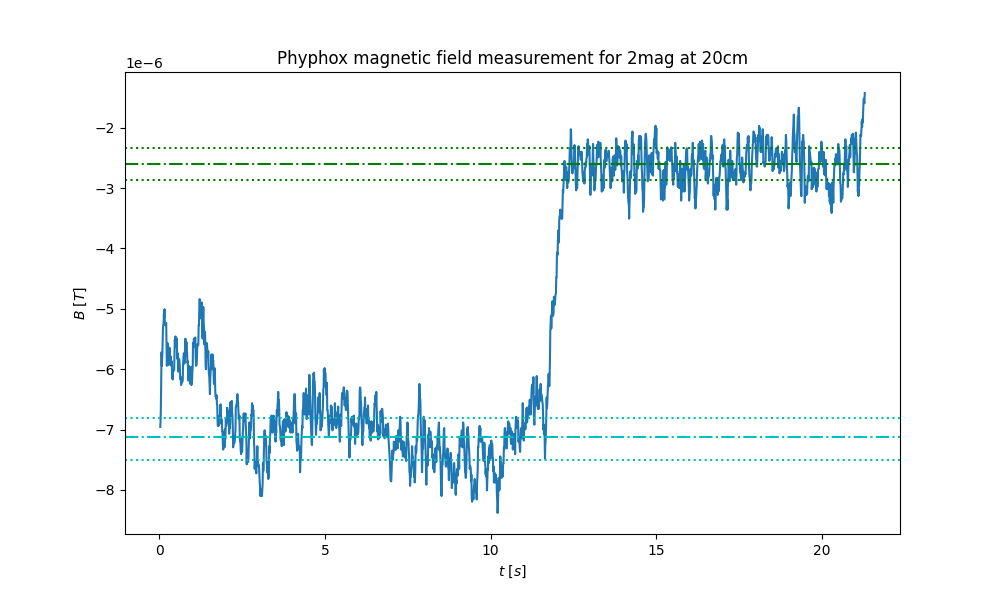

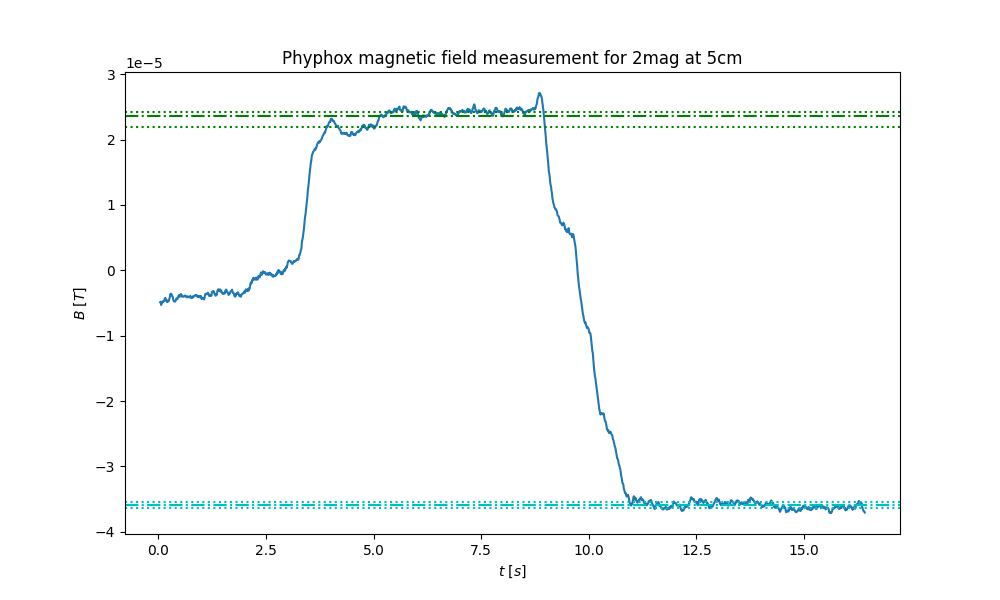

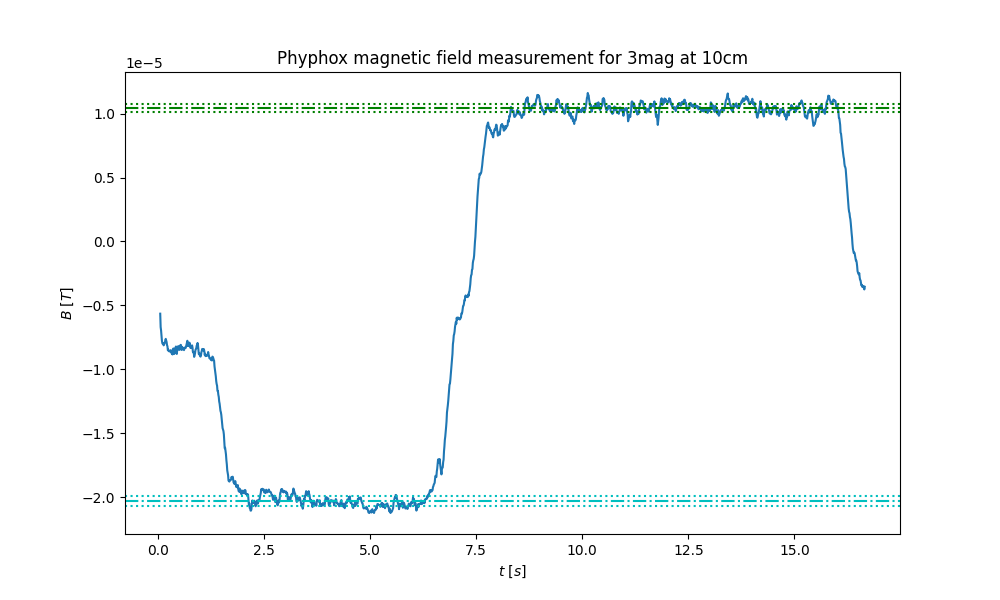

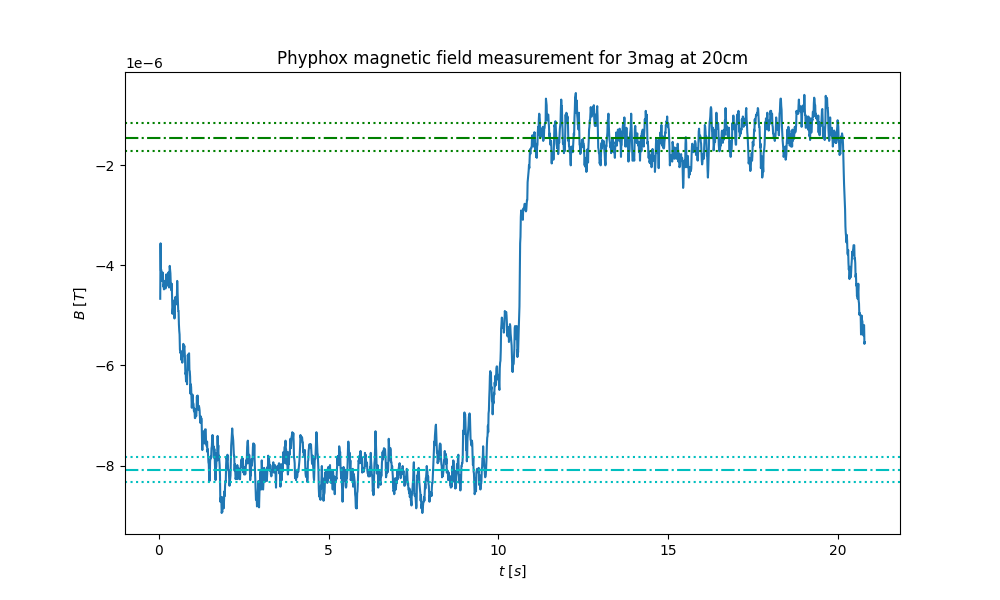

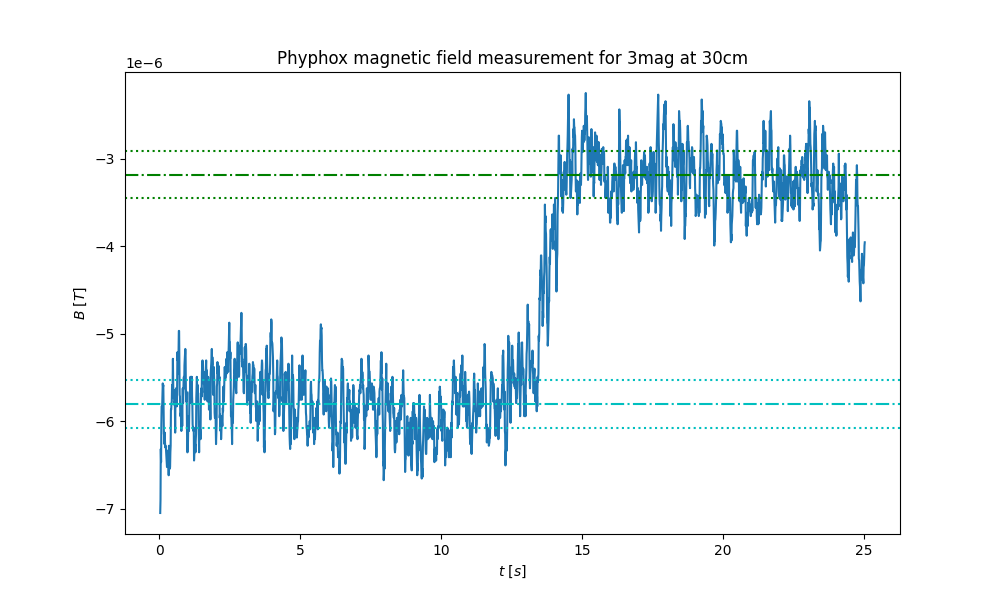

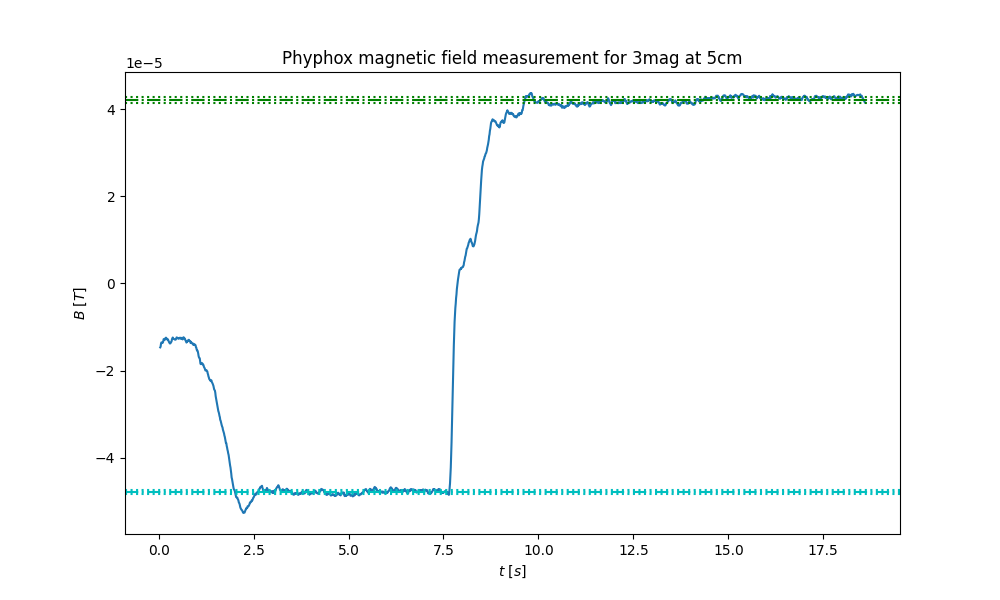

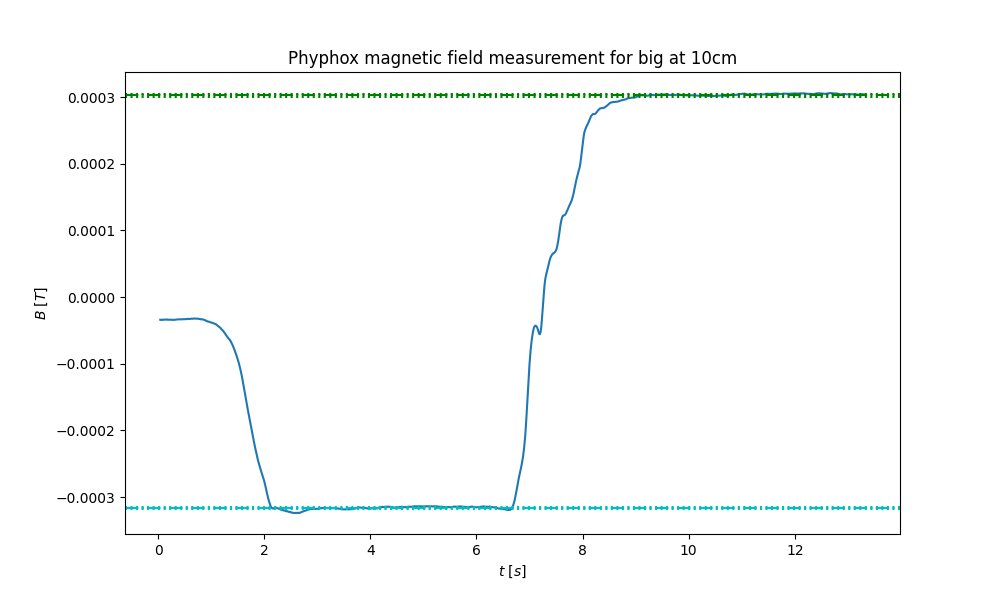

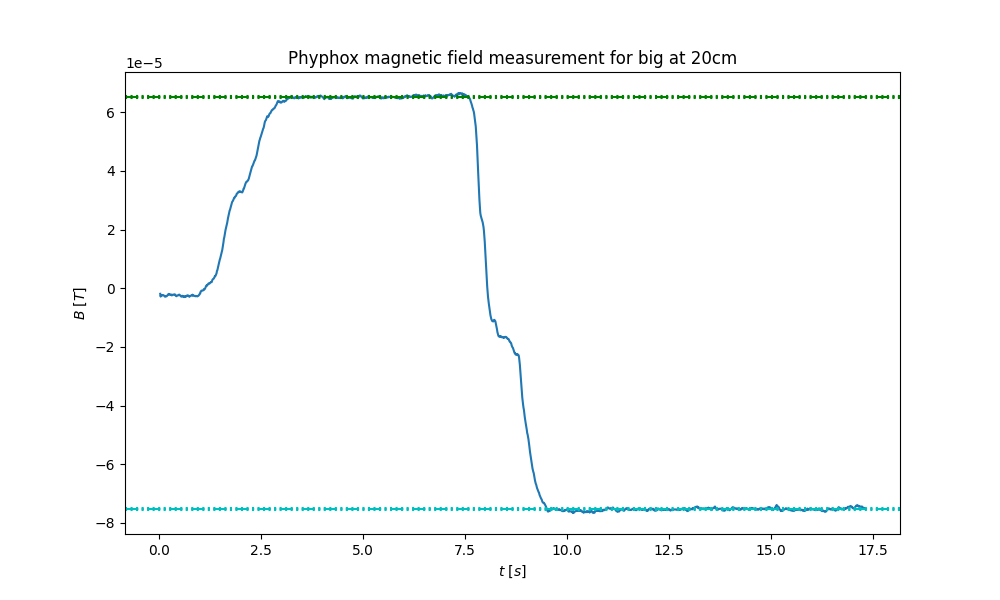

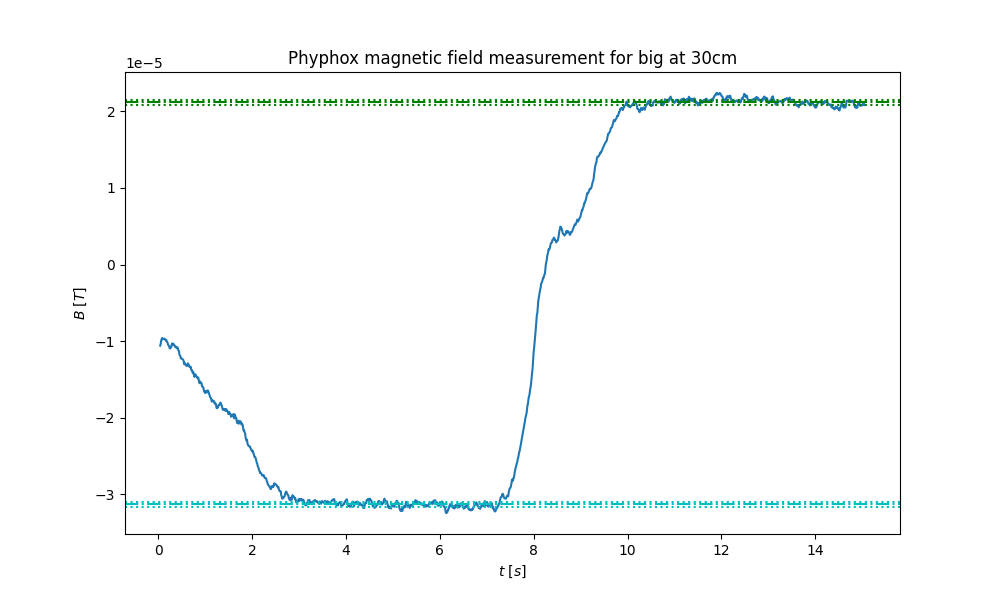

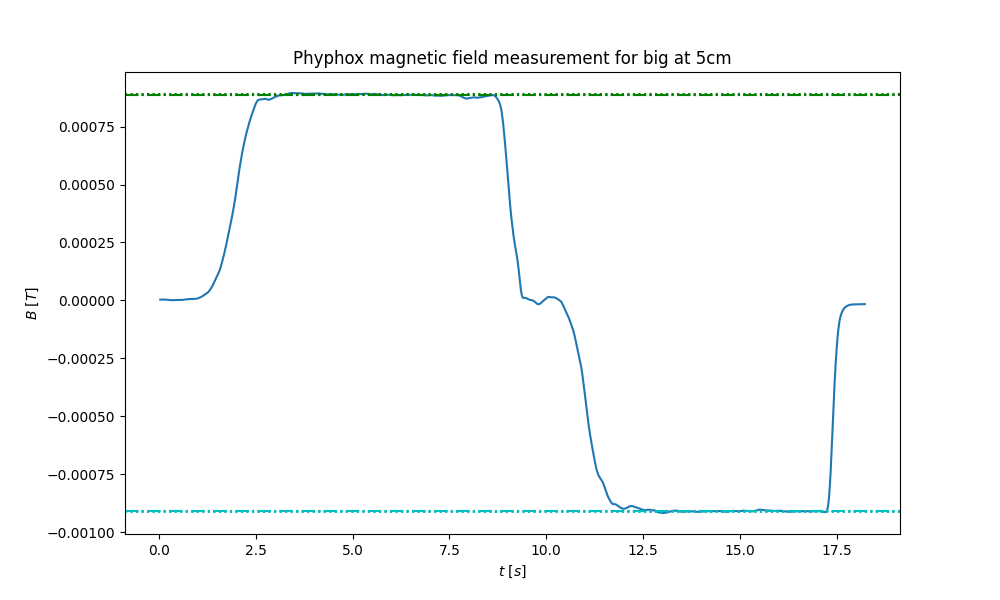

In [21]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math

%matplotlib widget

def lmap(f,x):
    return list(map(f,x))

def lfilt(f,x):
    return list(filter(f,x))

paths = [
    # "1mag_10cm.csv",
    # "1mag_20cm.csv",
    # "1mag_5cm.csv",
    "2mag_10cm.csv",
    "2mag_20cm.csv",
    "2mag_5cm.csv",
    "3mag_10cm.csv",
    "3mag_20cm.csv",
    "3mag_30cm.csv",
    "3mag_5cm.csv",
    "big_10cm.csv",
    "big_20cm.csv",
    "big_30cm.csv",
    "big_5cm.csv",
]

down_intervals = [
    # [5, 25],
    # [3, 8],
    # [10, 20],
    [7, 11],
    [2, 11],
    [11, 17],
    [2, 6],
    [2, 9],
    [0.5, 12],
    [3, 7],
    [2.5, 6.5],
    [10, 20],
    [3, 7],
    [13, 17]
]

up_intervals = [
    # [26, 40],
    # [9, 21],
    # [2, 8],
    [12, 18],
    [13, 22],
    [4, 8.5],
    [8.5, 15],
    [11, 19],
    [15, 24],
    [9.5, 20],
    [8.5, 13.5],
    [3, 7],
    [10, 15],
    [3, 8]
]

datas = {}

for i in range(len(paths)):
    path = paths[i]
    with open(f"./inputs/{path}", "r") as read:
        data = read.readlines()[1:]
        data = lmap(lambda row: row.rstrip().split(","), data)

        xdata = lmap(lambda row: float(row[0]), data)
        ydata = lmap(lambda row: float(row[1])/1000000, data)

        plt.figure(figsize=(10, 6))
        plt.plot(
            xdata,
            ydata,
        )

        # smooth_len = 200
        # ysmooth = np.convolve(
        #     ydata,
        #     np.ones(smooth_len) / smooth_len,
        #     "valid"
        # )

        # # ysmooth = lmap(lambda y: y / max(ysmooth), ysmooth)
        # amp1 = (max(ysmooth) - min(ysmooth)) / 2

        # plt.plot(
        #     xdata[int(smooth_len/2)-1:-int(smooth_len/2)],
        #     ysmooth,
        #     "r--"
        # )
        # plt.axhline(y=max(ysmooth), color="r", linestyle=':')
        # plt.axhline(y=min(ysmooth), color="r", linestyle=':')

        down_vals = lmap(lambda j: ydata[j], lfilt(lambda j: down_intervals[i][0] < xdata[j] < down_intervals[i][1], range(len(ydata))))
        up_vals = lmap(lambda j: ydata[j], lfilt(lambda j: up_intervals[i][0] < xdata[j] < up_intervals[i][1], range(len(ydata))))
        
        down_avg = np.average(down_vals)
        up_avg = np.average(up_vals)

        amp = (up_avg - down_avg) / 2

        down_error = [
            np.average(lmap(lambda x: down_avg - x, lfilt(lambda x: x <= down_avg, down_vals))),
            np.average(lmap(lambda x: x - down_avg, lfilt(lambda x: x > down_avg , down_vals)))
        ] 
        up_error = [
            np.average(lmap(lambda x: up_avg - x, lfilt(lambda x: x <= up_avg, up_vals))),
            np.average(lmap(lambda x: x - up_avg, lfilt(lambda x: x > up_avg , up_vals)))
        ] 

        if not (path.split("_")[0] in datas.keys()):
            datas[path.split("_")[0]] = {
                "x": [],
                "y": [],
                "fit_coefs" : [],
                "y_max_errors": [],
                "y_min_errors": [],
                "y_max_errors_perc": [],
                "y_min_errors_perc": [],
            }
        datas[path.split("_")[0]]["x"].append(float(path.split("_")[1].split("cm")[0]) / 100)
        datas[path.split("_")[0]]["y"].append(amp)
        datas[path.split("_")[0]]["y_max_errors"].append(down_error[1] + up_error[1])
        datas[path.split("_")[0]]["y_min_errors"].append(down_error[0] + up_error[0])
        datas[path.split("_")[0]]["y_max_errors_perc"].append(abs(down_error[1] / down_avg) + abs(up_error[1]/up_avg))
        datas[path.split("_")[0]]["y_min_errors_perc"].append(abs(down_error[0] / down_avg) + abs(up_error[0]/up_avg))

        # print(
        #     (down_error[1] + up_error[1])/amp, 
        #     (down_error[0] + up_error[0])/amp
        # )
        # print(
        #     abs(down_error[1] / down_avg) + abs(up_error[1]/up_avg),
        #     abs(down_error[0] / down_avg) + abs(up_error[0]/up_avg)
        # )
        # print(down_error[0] + up_error[0], down_error[1] + up_error[1], amp)

        plt.axhline(y=down_avg, color = "c", linestyle='-.')
        plt.axhline(y=down_avg - down_error[0], color = "c", linestyle=':')
        plt.axhline(y=down_avg + down_error[1], color = "c", linestyle=':')

        plt.axhline(y=up_avg, color = "g", linestyle='-.')
        plt.axhline(y=up_avg - up_error[0], color = "g", linestyle=':')
        plt.axhline(y=up_avg + up_error[1], color = "g", linestyle=':')
        plt.title(f"Phyphox magnetic field measurement for {path.split('_')[0]} at {path.split('_')[1].split('.')[0]}")
        plt.xlabel("$t$ $[s]$")
        plt.ylabel("$B$ $[T]$")
        
        print(amp, datas[path.split("_")[0]]["y_max_errors"])
        if(i == 0):
            plt.savefig("mag_field_measurement_2mag_10cm", dpi=1500)


[5.990948763401825e-07, 6.311923427513719e-07, 2.065532768968828e-06] [7.582608964979957e-07, 5.868906985742006e-07, 1.1636036495001797e-06]
[6.410944018381915e-07, 5.088905621400247e-07, 5.455321466047939e-07, 1.0813136139067118e-06] [7.37500856320103e-07, 5.631779199853357e-07, 5.393890465250522e-07, 1.0222409615704678e-06]
[4.832430128221115e-06, 6.437070649596539e-07, 7.016853085726856e-07, 4.4720433394072555e-06] [2.9363315385775676e-06, 6.31148673027724e-07, 5.883874044452878e-07, 4.680237902287782e-06]


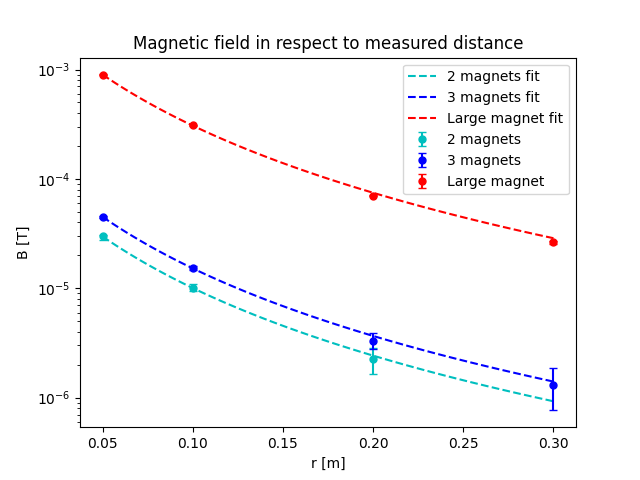

In [22]:
cols = {
    "1mag": "g",
    "2mag": "c",
    "3mag": "b",
    "big": "r" 
}

plt.figure()
plt.xlabel("r [m]")
plt.ylabel("B [T]")
plt.yscale("log")
for k in datas.keys():
    coef, cov = opt.curve_fit(
        lambda x, k, a: k/((x + a)**3),
        datas[k]["x"],
        datas[k]["y"],
        p0 = [1, 0.1],
        maxfev = 10000
    )

    plt.plot(
        np.linspace(0.05, 0.3, 100),
        lmap(
            lambda x: (coef[0] / ((x + coef[1])**3)),
            np.linspace(0.05, 0.3, 100)
        ),
        cols[k] + "--",
        label = f"{k} fit"
    )
    datas[k]["fit_coefs"] = coef
    # print(f"{coef[0]} / (x + {coef[1]})**3")

    print(
        datas[k]["y_min_errors"],
        datas[k]["y_max_errors"]
    )

    (_, caps, _) = plt.errorbar(datas[k]["x"], datas[k]["y"], yerr=[
        datas[k]["y_min_errors"],
        datas[k]["y_max_errors"]
    ], c = cols[k], fmt="o", label = k, markersize=5, capsize=3)

    for cap in caps:
        cap.set_markeredgewidth(1)

plt.title("Magnetic field in respect to measured distance")
plt.legend(["2 magnets fit", "3 magnets fit", "Large magnet fit", "2 magnets", "3 magnets", "Large magnet"])
plt.savefig("B_field_in_distance", dpi=1500)

plt.show()


In [23]:
rems = []

V = {
    "1mag": 0.005 * 0.005 * 0.005,
    "2mag": 0.005 * 0.005 * 0.005 * 2,
    "3mag": 0.005 * 0.005 * 0.005 * 3,
    "big": 0.047 * 0.022 * 0.0095,
}

finplot = {
    "1mag": {"x": [], "y": [], "yerr": [[],[]], "val": 0},
    "2mag": {"x": [], "y": [], "yerr": [[],[]], "val": 0},
    "3mag": {"x": [], "y": [], "yerr": [[],[]], "val": 0},
    "big": {"x": [], "y": [], "yerr": [[],[]], "val": 0},
}

# plt.figure()
# plt.ylim(0, 1.5)
# plt.xlabel("r [m]")
# plt.ylabel("B_r [T]")
for k in datas.keys():
    x = []
    y = []
    y_err = []

    for i in range(len(datas[k]["x"])):

        def B_r(r, B):
            return 2 * math.pi * B * math.pow(r, 3) / V[k]

        r = datas[k]["x"][i] + datas[k]["fit_coefs"][1]
        B = datas[k]["y"][i]

        _B_r = B_r(r, B)
        _B_r_err_min = B_r(r, datas[k]["y_min_errors"][i] + B) - _B_r
        _B_r_err_max = B_r(r, datas[k]["y_max_errors"][i] + B) - _B_r

        # (_, caps, _) = plt.errorbar(
        #     r - datas[k]["fit_coefs"][1],
        #     _B_r,
        #     yerr=[[_B_r_err_min], [_B_r_err_max]],
        #     c=cols[k],
        #     fmt="o",
        #     label=k if i == 0 else None,
        #     markersize=5,
        #     capsize=3,
        # )

        # for cap in caps:
        #     cap.set_markeredgewidth(1)

        x.append(r)
        y.append(_B_r)

        # x.append(r)
        # x.append(r)
        # y.append(_B_r - _B_r_err_min)
        # y.append(_B_r + _B_r_err_max)

        finplot[k]["x"].append(
            r - datas[k]["fit_coefs"][1]
        )
        finplot[k]["y"].append(
            _B_r
        )
        finplot[k]["yerr"][0].append(
            _B_r_err_min
        )
        finplot[k]["yerr"][1].append(
            _B_r_err_min
        )

    coef = np.polyfit(x, y, 0)
    rems.append(coef[-1])
    # plt.plot(
    #     np.linspace(0, 0.35, 100),
    #     lmap(lambda x: coef[0], np.linspace(0, 0.3, 100)),
    #     f"{cols[k]}--",
    # )

    finplot[k]["val"] = coef[-1]

# plt.legend()

## Výpočet
$$
|B| = \frac{{\mu}_0 m}{2\pi r^3}
$$

$$
m = \frac{1}{{\mu}_0} B_r V
$$

$$
B_r = \frac{2\pi r^3 B}{V}
$$

# Force calculations

[7.94798824e-09]


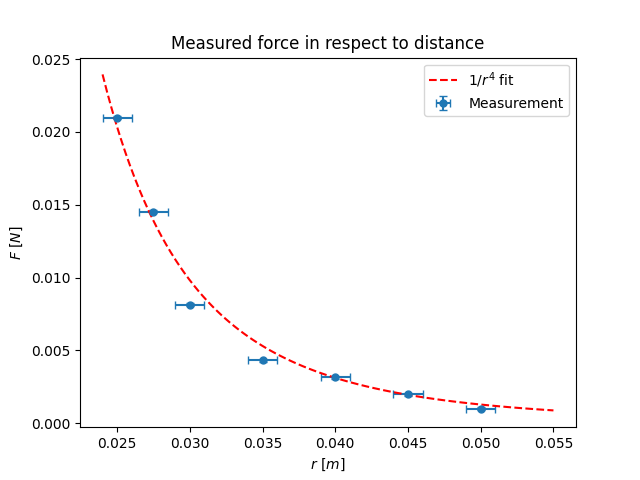

In [24]:
def lmap(f,x):
    return list(map(f,x))

# MEASURED DATA
xdata = [
    0.05, # meters
    0.045,
    0.04,
    0.035,
    0.03,
    0.0275,
    0.025,
]
errx=0.001
erry=0.01 * 9.81/1000

ydata = lmap(lambda g: g * 9.81 / 1000, [
    0.10, # grams
    0.20,
    0.32,
    0.44,
    0.83,
    1.48,
    2.14
])

plt.figure()
plt.xlabel("$r$ $[m]$")
plt.ylabel("$F$ $[N]$")
(_, caps, _) = plt.errorbar(
    xdata,
    ydata,
    xerr=errx,
    yerr=erry,
    fmt="o",
    markersize=5,
    capsize=3,
)

for cap in caps:
    cap.set_markeredgewidth(1)

coef, cov = opt.curve_fit(
    lambda x, k: k/((x)**4),
    xdata,
    ydata,
    p0 = [0.1],
    maxfev = 10000
)

print(coef)

plt.plot(
    np.linspace(0.024, 0.055, 100),
    lmap(
        lambda x: (coef[0] / ((x)**4)),
        np.linspace(0.024, 0.055, 100)
    ),
    "r--",
    label = f"1mag fit"
)
plt.title("Measured force in respect to distance")
plt.legend(["$1/r^4$ fit","Measurement"])

plt.savefig("F_in_distance", dpi=1500)

[1.10574096]
0.8701359766320094
0.12328306771796826
0.014113979968506834


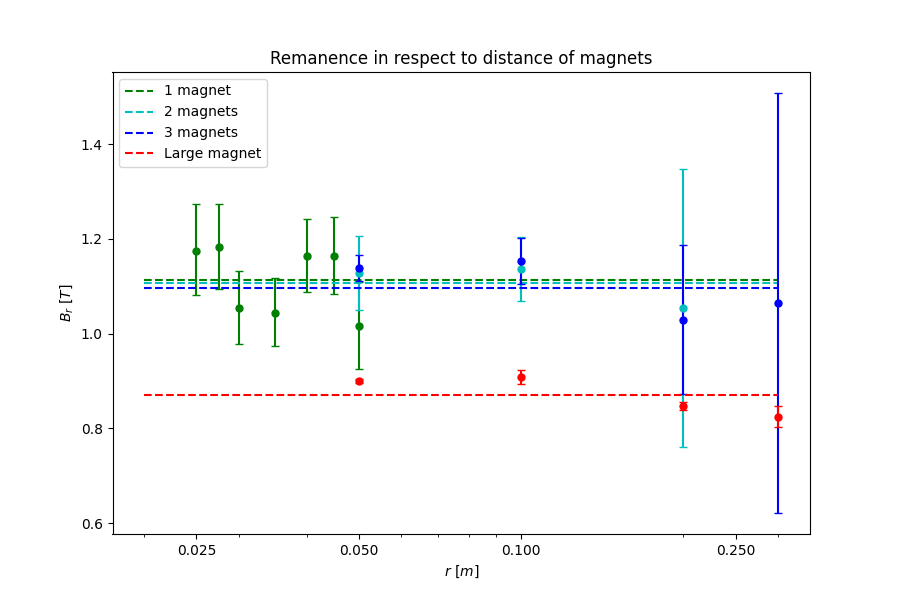

In [25]:
B_rs = []
yerr_0 = []
yerr_1 = []

mu_0 = 1.25663706212e-6
V = 0.005**3
for i in range(len(xdata)):
    r = xdata[i]
    F = ydata[i]
    # B_r = F * 2 * math.pi * r**4 / (3 * V)
    def B_r(_r, _F):
        return math.sqrt(_F * 2 * math.pi * _r**4 * mu_0 / (3 * V**2))
    _B_r = B_r(r, F)

    B_rs.append(_B_r)
    yerr_0.append(abs(B_r(r - errx, F - erry) - _B_r))
    yerr_1.append(abs(B_r(r + errx, F + erry) - _B_r))

coef = np.polyfit(xdata, B_rs, 0)

finplot["1mag"]["x"] = xdata
finplot["1mag"]["y"] = B_rs
finplot["1mag"]["yerr"][0] = yerr_0
finplot["1mag"]["yerr"][1] = yerr_1
finplot["1mag"]["val"] = coef

fig,ax=plt.subplots(figsize=(9, 6))
plt.title("Remanence in respect to distance of magnets")

# plt.ylim(0, 1.5)
plt.ylabel("$B_r$ $[T]$")


ax.set_xscale('log')
ax.set_xticks([0.005, 0.025, 0.05, 0.1, 0.25])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.get_xaxis().set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))
plt.xlabel("$r$ $[m]$")

for k in finplot.keys():
    (_, caps, _) = plt.errorbar(
        finplot[k]["x"],
        finplot[k]["y"],
        yerr=finplot[k]["yerr"],
        c=cols[k],
        fmt="o",
        label=k if i == 0 else None,
        markersize=5,
        capsize=3,
    )

    for cap in caps:
        cap.set_markeredgewidth(1)

    plt.plot(
        np.linspace(0.02, 0.3, 100),
        lmap(lambda x: finplot[k]["val"], np.linspace(0.02, 0.05, 100)),
        f"{cols[k]}--",
        label = k
    )

print(
    (finplot["1mag"]["val"] + 
    finplot["2mag"]["val"] + 
    finplot["3mag"]["val"]) / 3
)
print(finplot["big"]["val"])
plt.legend(["1 magnet", "2 magnets", "3 magnets", "Large magnet"])

plt.savefig("Final_remanence", dpi=1500)

print(
    np.average([
        np.average(np.array(finplot["1mag"]["yerr"]) / np.array(finplot["1mag"]["y"])),
        np.average(np.array(finplot["2mag"]["yerr"]) / np.array(finplot["2mag"]["y"])),
        np.average(np.array(finplot["3mag"]["yerr"]) / np.array(finplot["3mag"]["y"]))
    ])
)
print(np.average(np.array(finplot["big"]["yerr"]) / np.array(finplot["big"]["y"])))


## Výpočet
$$
|F| =  \frac{3 {\mu}_0}{2\pi r^4}m^2
$$

$$
m = \frac{1}{{\mu}_0} B_r V
$$

$$
B_r = \sqrt{\frac{2\pi {\mu}_0 r^4 F}{3 V^2}}
$$

# Final measured remanence:
$$B_r = 1.1049 T$$
$$B_r = 1.10(13) T$$

$$B_{r_{xl}} = 0.87(5)T$$